# Background

The purpose of this project is to explore the dataset generated by multiple motion/vital sensors on 10 human volunteers. The dataset was provided for reaseach purposese by Oresti Baños, et al., at the University of Granada. 

If a model can be constructed that can predict subjects' instantaneous motion with high accuracy, it can be really beneficial in some cases when subjects want to be monitored for their own goods (i.e. health-related issues). However, in cases when subjects do not want to be monitored, such a model may be undesirable. Unfortunately, mobile phones with various types of high-quality sensors are ubiquitous in these days.

This project will focus on the latter case mentioned above. Followed by the detailed EDA, a few models will be trained with different subsets of data to investigate how accurately the model can predict the motion with sensor data. In parallel, similar models will be trained and investigated for slightly different purpose; to see if the model would be able to identify specific subject based on the sensor data.

Ten volunteers with diverse profiles performed 12 physical activities (motions).

* motion 1: Standing still (1 min)
* motion 2: Sitting and relaxing (1 min) 
* motion 3: Lying down (1 min) 
* motion 4: Walking (1 min) 
* motion 5: Climbing stairs (1 min) 
* motion 6: Waist bends forward (20x) 
* motion 7: Frontal elevation of arms (20x)
* motion 8: Knees bending (crouching) (20x)
* motion 9: Cycling (1 min)
* motion 10: Jogging (1 min)
* motion 11: Running (1 min)
* motion 12: Jump front & back (20x)

While performing the exercise, the following sensors were placed at differet parts of the body.

* Accelerometer on chest (X-, Y-, Z-axis) + 2 ECG
* Accelerometer on left ankle (X-, Y-, Z-axis)
* Gyrometer on left ankle (X-, Y-, Z-axis)
* Magnetometer on left ankle (X-, Y-, Z-axis)
* Accelerometer on right lower arm (X-, Y-, Z-axis)
* Gyrometer on right lower arm (X-, Y-, Z-axis)
* Magnetometer on right lower arm (X-, Y-, Z-axis)

All sensing modalities are recorded at a sampling rate of 50 Hz.

# Data overview

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Dataset comes in 10 different log files (one from each individual). It requires some cleanings before performing any analysis. 
#### Data loading and cleaning

In [2]:
columns = ['accel_chest_x','accel_chest_y','accel_chest_z','ECG_1','ECG_2','accel_L_ankle_x','accel_L_ankle_y','accel_L_ankle_z',
          'gyro_L_ankle_x','gyro_L_ankle_y','gyro_L_ankle_z','mag_L_ankle_x','mag_L_ankle_y','mag_L_ankle_z','accel_R_LA_x',
          'accel_R_LA_y','accel_R_LA_z','gyro_R_LA_x','gyro_R_LA_y','gyro_R_LA_z','mag_R_LA_x','mag_R_LA_y','mag_R_LA_z','label','subject']

df_full = pd.DataFrame()
# 10 participants
for i in range(1,11):
    df = pd.read_csv('dataset_MobileHumanMotionPrediction\mHealth_subject'+str(i)+'.log',sep='\t',header=None)
    df = df[df[23]!=0] #get rid of null label data
    df.loc[:,'dummy'] = i
    df_full = df_full.append(df)
df_full = df_full.reset_index(drop=True)
df_full.columns = columns
record_full = df_full.copy()

In each file, the "null" state (period between each motion) is labeled as 0. Since this project is specifically interested in motion prediction, this "noise" will be excluded. Since each file does not have an indicator for subject, a new column (`subject`) is generated.  Then, all files are merged into a single dataframe that contains all information needed for further analysis. The column names are missing, so this also need to be added.

#### Data strucutre and chekcing for NaNs

In [3]:
record_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343195 entries, 0 to 343194
Data columns (total 25 columns):
accel_chest_x      343195 non-null float64
accel_chest_y      343195 non-null float64
accel_chest_z      343195 non-null float64
ECG_1              343195 non-null float64
ECG_2              343195 non-null float64
accel_L_ankle_x    343195 non-null float64
accel_L_ankle_y    343195 non-null float64
accel_L_ankle_z    343195 non-null float64
gyro_L_ankle_x     343195 non-null float64
gyro_L_ankle_y     343195 non-null float64
gyro_L_ankle_z     343195 non-null float64
mag_L_ankle_x      343195 non-null float64
mag_L_ankle_y      343195 non-null float64
mag_L_ankle_z      343195 non-null float64
accel_R_LA_x       343195 non-null float64
accel_R_LA_y       343195 non-null float64
accel_R_LA_z       343195 non-null float64
gyro_R_LA_x        343195 non-null float64
gyro_R_LA_y        343195 non-null float64
gyro_R_LA_z        343195 non-null float64
mag_R_LA_x         343195 non

In [4]:
record_full.isnull().any()[record_full.isnull().any()==True]

Series([], dtype: bool)

The dataset is composed of 343,195 rows with 25 columns. All features and labels are numeric. This dataset contains no missing values. 
#### Target variable distribution

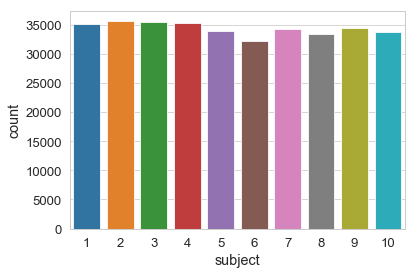

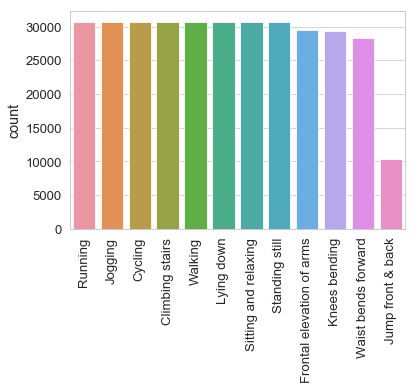

In [5]:
sns.set_style("whitegrid")
label_map = {1: 'Standing still', 2: 'Sitting and relaxing',3: 'Lying down', 4: 'Walking', 5: 'Climbing stairs',
             6:'Waist bends forward',7:'Frontal elevation of arms',8: 'Knees bending',9: 'Cycling',10: 'Jogging',
             11: 'Running',12: 'Jump front & back'}
sns.set_context("paper", font_scale=1.5)                                                  
plt.figure()
sns.countplot(record_full.subject)

plt.figure()
sns.countplot(record_full.label.map(label_map),order = record_full.label.value_counts().index.map(lambda x: label_map[x]))
plt.xticks(rotation=90)
plt.xlabel('')
plt.show()

The first figure shows general distribution of subject data, and it is well balanced. This was somewhat expected since all subjects performed the same sets of motion. Some variation still exist because some motions such as *motion 6* was measured by number of repetition (not by time). So it seems like `subject`#6 performed those motiones at a faster rate than other subjects.

The second figure shows distribution of motion data. While other motions contain similiar amount of data, *motion 12* (`Jump front&back`) contains much less. This can be interpreted as that the subjects in general performed jumping front&back (X20) in ~ 20 seconds. Would this deteriorate the prediction accuracy for *motion 12*? If yes, oversampling of *motion 12* can be easily done since the nature of this dataset is already repetative.
#### Signal trace examples

In [6]:
def signal_t(df,label,subject,sensor):
    df_specific = df[(df.label==label)&(df.subject==subject)]
    fs = 50
    N = len(df_specific[sensor])
    dt = 1/fs
    t = np.arange(0,N*dt,dt)
    plt.plot(t,df_specific[sensor])
    plt.xlabel('time (s)')
    if sensor.startswith('accel'):
        unit = 'm/s^2'
    elif sensor.startswith('gyro'):
        unit = 'deg/s'
    elif sensor.startswith('magnetic'):
        unit = 'local'
    else:
        unit = 'mV'
    plt.ylabel('magnitude ('+unit+')')
def signal_f(df,label,subject,sensor):
    df_specific = df[(df.label==label)&(df.subject==subject)]
    fs = 50
    N = len(df_specific[sensor])
    f_axis = np.arange((-fs/2),(fs/2),fs/N)
    f_amp = np.abs(np.fft.fftshift(np.fft.fft(df_specific[sensor])))
    plt.plot(f_axis,f_amp)
    ax = plt.gca()
    ax.set_xlim([0,(fs/2)])
    plt.xlabel('frequency (Hz)')
    if sensor.startswith('accel'):
        unit = 'm/s^2'
    elif sensor.startswith('gyro'):
        unit = 'deg/s'
    elif sensor.startswith('magnetic'):
        unit = 'local'
    else:
        unit = 'mV'
    plt.ylabel('magnitude ('+unit+')')

(0, 2000)

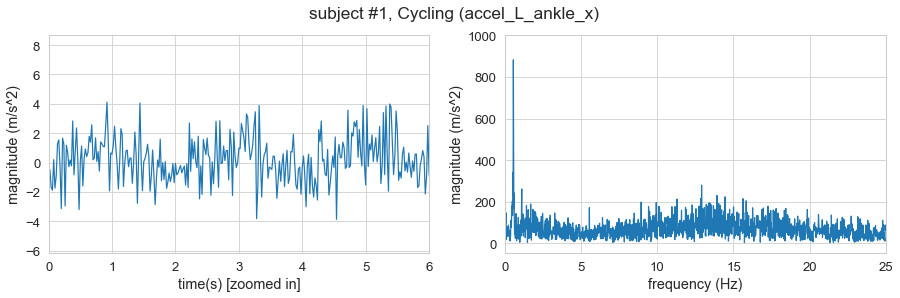

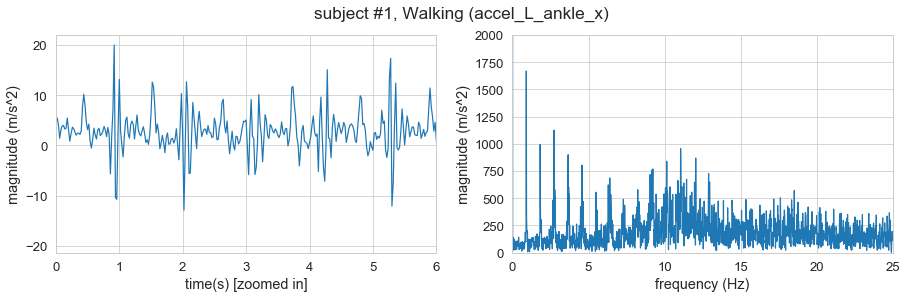

In [7]:
sns.set_style("whitegrid")
label = 9
subject = 1
sensor = 'accel_L_ankle_x'
fig = plt.figure(figsize=(15,4))
fig.suptitle('subject #'+str(subject)+', '+str(label_map[label])+' ('+sensor+')')
plt.subplot(121)
signal_t(record_full,label,subject,sensor)
plt.xlabel('time(s) [zoomed in]')
plt.xlim([0,6])
plt.subplot(122)
signal_f(record_full,label,subject,sensor)

label = 4
subject = 1
sensor = 'accel_L_ankle_x'
fig = plt.figure(figsize=(15,4))
fig.suptitle('subject #'+str(subject)+', '+str(label_map[label])+' ('+sensor+')')
plt.subplot(121)
signal_t(record_full,label,subject,sensor)
plt.xlabel('time(s) [zoomed in]')
plt.xlim([0,6])
plt.subplot(122)
signal_f(record_full,label,subject,sensor)
plt.ylim([0,2000])

Since the sensor data are time-series where signals propagate over time, it is helpful to see if their actual signal traces differ by subjects and motions. By chaning the `label`, `subject` and `sensor` parameters in the functions defined, the sensor signals of specific motion and subject can be depicted in the time- and frequency-domain. While different signals look quite simliar in the time-domain, their difference can be clearly seen in terms of their associated frequency information. 

Since this dataset is dealing with 23 different features (+1 subject and +1 motion), it is really diffulct to visualize all combinations of different features. Instead, t-SNE can be performed to see if each motion and each subject are forming specific clusters in 2D feature space. 
#### Data filtering for t-SNA

In [8]:
record_reduced = record_full[::50] #1Hz sampling freq
record_reduced.shape

(6864, 25)

Usually, other dimentionality reduction techniques like PCA is recommended before performing t-SNE. However, for 25 features, it can be performed directly.

However, still, in order to perform this computationally expensive t-SNE efficiently, the amount of data needs to be shrinked. This can be achieved by only selecting information every 50 entry as if the data was collected at ***1MHz sampling*** frequency.
#### t-SNA

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
X = record_reduced.drop(['subject','label'],axis=1) #subject feature cause data leakage
y = record_reduced[['subject','label']]

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
tsne = TSNE(random_state=100,verbose=1,perplexity=90)
X_scaled_tsne = tsne.fit_transform(X_scaled)

[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 6864 samples in 0.007s...
[t-SNE] Computed neighbors for 6864 samples in 2.899s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6864
[t-SNE] Computed conditional probabilities for sample 2000 / 6864
[t-SNE] Computed conditional probabilities for sample 3000 / 6864
[t-SNE] Computed conditional probabilities for sample 4000 / 6864
[t-SNE] Computed conditional probabilities for sample 5000 / 6864
[t-SNE] Computed conditional probabilities for sample 6000 / 6864
[t-SNE] Computed conditional probabilities for sample 6864 / 6864
[t-SNE] Mean sigma: 1.036887
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.078316
[t-SNE] KL divergence after 1000 iterations: 0.914615


In [10]:
df_tsna = pd.concat([pd.DataFrame(X_scaled_tsne,columns=['tsna_0','tsna_1']),y.subject.reset_index(drop=True),y.label.map(lambda x: label_map[x]).reset_index(drop=True)],axis=1)

#### t-SNA figure by motion

<Figure size 432x288 with 0 Axes>

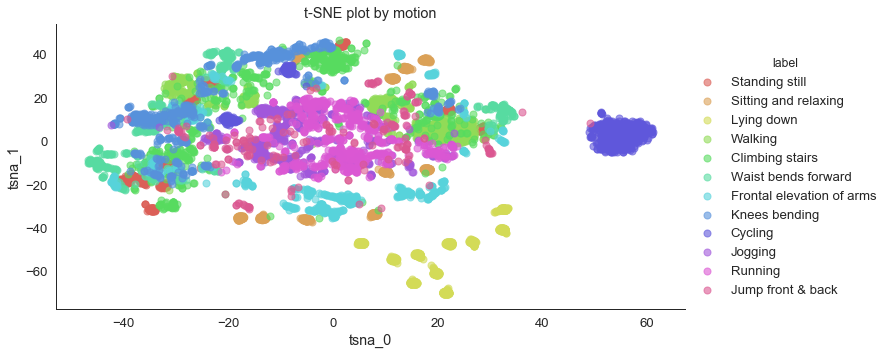

In [11]:
sns.set_style("white")
plt.figure()
sns.lmplot('tsna_0','tsna_1',hue='label',fit_reg=False,scatter_kws={'alpha':0.6,"s": 50},
           data=df_tsna,aspect=2,palette=sns.color_palette("hls", 12),hue_order=label_map.values())
plt.title('t-SNE plot by motion')
plt.show()

#### t-SNA figure by motion of specific subject

<Figure size 432x288 with 0 Axes>

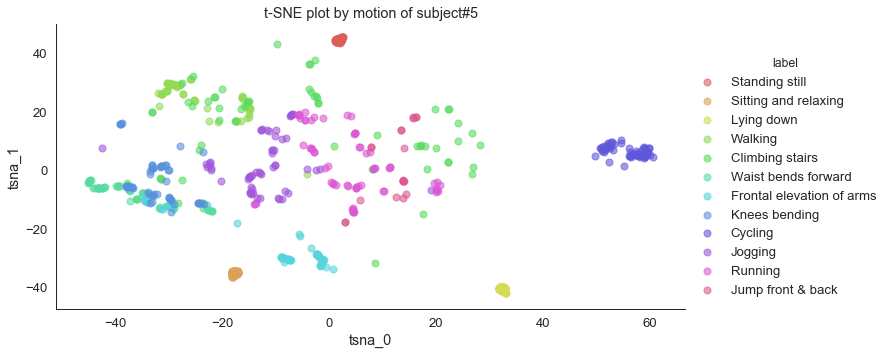

In [12]:
plt.figure()
sns.lmplot('tsna_0','tsna_1',hue='label',fit_reg=False,scatter_kws={'alpha':0.6,"s": 50},
           data=df_tsna[df_tsna['subject']==5],aspect=2,palette=sns.color_palette("hls", 12),hue_order=label_map.values())
plt.title('t-SNE plot by motion of subject#5')
plt.show()

From the t-SNE figures, it seems like the motions are relatively well separated. Especially `Cycling` is forming a clear cluster on the right side of the figure.

The same t-SNA figure can be hued by `subject` to see if subjects are forming different groups.

#### t-SNA figure by subject

<Figure size 432x288 with 0 Axes>

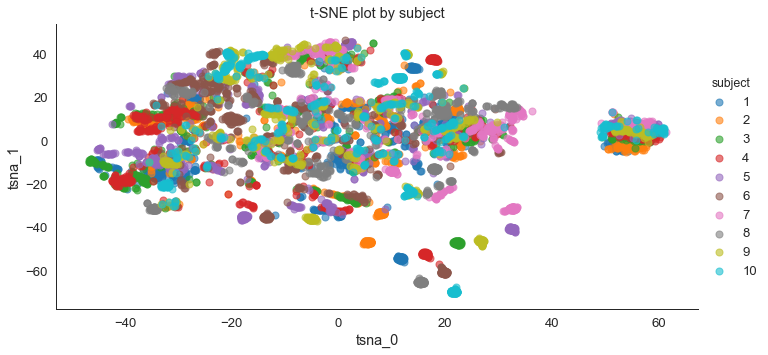

In [13]:
plt.figure()
sns.lmplot('tsna_0','tsna_1',hue='subject',fit_reg=False,scatter_kws={'alpha':0.6,"s": 50},
           data=df_tsna,aspect=2)
plt.title('t-SNE plot by subject')
plt.show()

#### t_SNA figure by subject during specific motion

<Figure size 432x288 with 0 Axes>

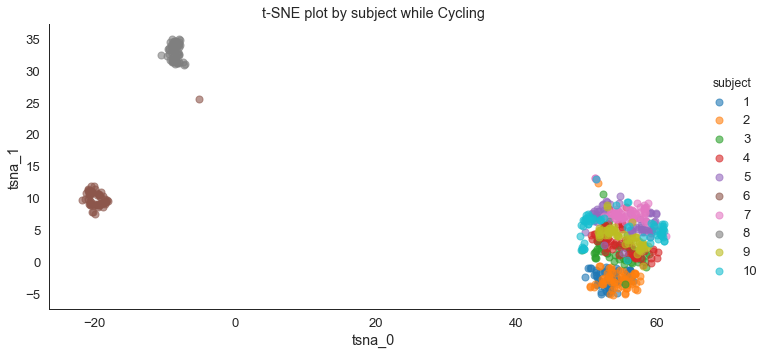

In [14]:
plt.figure()
sns.lmplot('tsna_0','tsna_1',hue='subject',fit_reg=False,scatter_kws={'alpha':0.6,"s": 50},
           data=df_tsna[df_tsna['label']=='Cycling'],aspect=2)
plt.title('t-SNE plot by subject while Cycling')
plt.show()

Things are overlapping and look more difficult to separate. Looking at the Cycling cluster, it can be seen that there are separable groups of subject with similar pattern.

# Model fitting with full data (1-min-long) - XGB Classifier
While the shirkned data was used for visualization purposes, for the model fitting, the entire dataset (~1 min (~20 sec for `Jump front&back`) with 50Hz sampling frequency) can be utilized for the intial trial. The features are grouped as `X`, but target variables are divided into `y_subject` and `y_label` in order to fit two models with different purposes.

The hyperparameters of the model will not be optimized for this project. 

In [15]:
from xgboost import XGBClassifier, plot_importance

X = record_full.drop(['subject','label'],axis=1)
y = record_full[['subject','label']]
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=100)
y_train_subject = y_train.subject
y_train_label = y_train.label
y_test_subject = y_test.subject
y_test_label = y_test.label

#### Model fitting and evaluation on the test set

In [16]:
xgbc_motion = XGBClassifier().fit(X_train,y_train_label)
xgbc_subject = XGBClassifier().fit(X_train,y_train_subject)

In [17]:
print('Accurcay to predict motion: {:.3f}'.format(xgbc_motion.score(X_test,y_test_label)))
print('Accuracy to predict subject: {:.3f}'.format(xgbc_subject.score(X_test,y_test_subject)))

Accurcay to predict motion: 0.957
Accuracy to predict subject: 0.839


#### Feature importance of each model

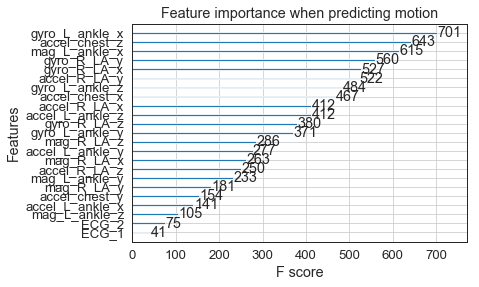

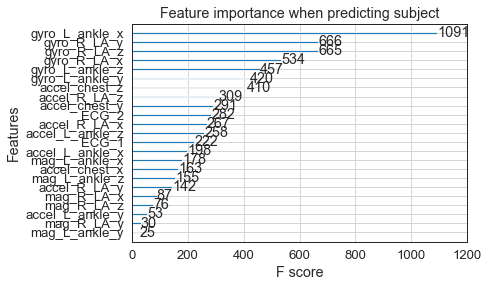

In [18]:
plot_importance(xgbc_motion,title='Feature importance when predicting motion')
plot_importance(xgbc_subject,title='Feature importance when predicting subject')

So it turns out that, **with 1-min observation**, the model can be trained to **predict motion with ~96% accuracy**. Moreover, even though it was only 10 subjects that was considered, the model could **identify the subject with ~84% accuracy**.

This can be investigated further by being **more specific**:
In most cases, sensory devices (i.e. medical monitoring device or cellphone) *belong to a specific subject*. So if the device is trained only by the data of specific personnel, the accuracy of motion prediction may increase.

#### Model for personal motion prediction 

In [19]:
from sklearn.metrics import accuracy_score

subject_motion = []
for subject in np.sort(record_full.subject.unique()):
    record_motion = record_full[record_full.subject==subject]
    X = record_motion.drop(['subject','label'],axis=1) #subject feature cause data leakage
    y = record_motion[['subject','label']]

    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=100)
    y_train_label = y_train.label
    y_test_label = y_test.label
    
    xgbc = XGBClassifier().fit(X_train,y_train_label)
    top3 = pd.DataFrame(xgbc.feature_importances_,index=X_train.columns,columns=['F score']).sort_values('F score',ascending=False).index[0:3].tolist()
    
    y_predicted = xgbc.predict(X_test)
    acc_score = accuracy_score(y_test_label,y_predicted)
    subject_motion.append([subject,acc_score.round(3),top3[0],top3[1],top3[2]])
pd.DataFrame(subject_motion,columns=['Subject','Accuracy','Feature1','Feature2','Feature3']).set_index('Subject')

,Accuracy,Feature1,Feature2,Feature3
Subject,,,,
1,0.998,gyro_L_ankle_x,gyro_L_ankle_z,accel_chest_z
2,0.980,gyro_L_ankle_x,gyro_L_ankle_z,gyro_R_LA_y
3,0.998,gyro_L_ankle_x,gyro_R_LA_x,gyro_L_ankle_z
4,1.000,gyro_L_ankle_x,gyro_L_ankle_z,gyro_R_LA_x
5,0.998,gyro_L_ankle_x,gyro_R_LA_x,gyro_R_LA_z
6,0.998,gyro_R_LA_y,gyro_L_ankle_x,gyro_R_LA_z
7,1.000,gyro_L_ankle_x,gyro_R_LA_x,gyro_R_LA_y
8,1.000,gyro_R_LA_y,gyro_L_ankle_z,gyro_L_ankle_x
9,0.999,gyro_L_ankle_x,gyro_R_LA_y,gyro_R_LA_x


The result shows the accuracy in **motion prediction increase to ~100% for each individual** when the model is trained by the specific individual data. This makes sense because now the variation among different individual is excluded from the model training.

Based on the top 3 important features of each model, it is shown that the models heavily depend on **gyro** sensors to make prediction. 

Similiarly, the specific models can be investigated to see if the model can identify specific subjects based on a single motion information.
#### Model for identifying subject based on motions  

In [20]:
motion_subject = []
for motion in np.sort(record_full.label.unique()):
    record_motion = record_full[record_full.label==motion]
    X = record_motion.drop(['subject','label'],axis=1) #subject feature cause data leakage
    y = record_motion[['subject','label']]

    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=100)
    y_train_subject = y_train.subject
    y_test_subject = y_test.subject
    
    xgbc = XGBClassifier().fit(X_train,y_train_subject)
    top3 = pd.DataFrame(xgbc.feature_importances_,index=X_train.columns,columns=['F score']).sort_values('F score',ascending=False).index[0:3].tolist()
    
    y_predicted = xgbc.predict(X_test)
    acc_score = accuracy_score(y_test_subject,y_predicted)
    motion_subject.append([label_map[motion],acc_score.round(3),top3[0],top3[1],top3[2]])
pd.DataFrame(motion_subject,columns=['Motion','Accuracy','Feature1','Feature2','Feature3']).set_index('Motion')

,Accuracy,Feature1,Feature2,Feature3
Motion,,,,
Standing still,1.000,gyro_L_ankle_x,accel_chest_z,accel_L_ankle_x
Sitting and relaxing,1.000,gyro_R_LA_y,gyro_L_ankle_y,accel_R_LA_y
Lying down,1.000,accel_chest_x,accel_chest_y,gyro_L_ankle_y
Walking,0.984,gyro_L_ankle_x,gyro_R_LA_x,gyro_R_LA_z
Climbing stairs,0.859,gyro_L_ankle_y,gyro_L_ankle_x,accel_chest_z
Waist bends forward,0.999,gyro_L_ankle_x,gyro_L_ankle_z,gyro_L_ankle_y
Frontal elevation of arms,1.000,gyro_L_ankle_x,gyro_L_ankle_z,accel_L_ankle_x
Knees bending,0.994,gyro_L_ankle_x,gyro_R_LA_x,gyro_R_LA_y
Cycling,0.989,gyro_R_LA_y,gyro_R_LA_z,gyro_L_ankle_x


The result shows that the model without any hyperparameter tuning can **identify the subject with ~95% accuracy** when the subject is in a specific type of motion that the model is trained for. The only exception is the `climbing stairs` where the accuracy is only ~86%. Surprisingly, **even when the subject is in a relatively static motion (i.e. `standing`, `sitting`, `laying`), the model is shown to identify different subjects**.  

# Model fitting with small subset of data (0.5-second-long) - XGB Classifier
The above case is when the model is trained with "tremendous" amount of data. However, the nature of human motion is quite repetative, and therefore, the model may not need the entire 1-min-long data to achieve high accuracy in prediction. In order to test this, only the small subset of data (still at 50Hz sampling frequency) is filtered to train the models. In this case, the first 0.5-sec-long data is selected for each motion (~0.15 sec in case of `Jump front&back`).
#### Data loading and cleaning

In [21]:
data_duration = 0.5
factor = 60/data_duration
df_full = pd.DataFrame()
# 10 participants
for i in range(1,11):
    df = pd.read_csv('dataset_MobileHumanMotionPrediction\mHealth_subject'+str(i)+'.log',sep='\t',header=None)
    df = df[df[23]!=0] #get rid of null label data
    df.loc[:,'dummy'] = i
    df_subject = pd.DataFrame()
    for label in df[23].unique():
        sub_df = df[df[23]==label]
        sub_df = sub_df.iloc[0:round(len(sub_df)/factor)]
        df_subject = df_subject.append(sub_df)
    df_full = df_full.append(df_subject)
df_full = df_full.reset_index(drop=True)
df_full.columns = columns
record_full = df_full.copy()

#### Target variable distribution

Text(0.5, 0, '')

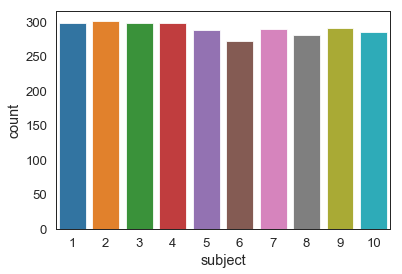

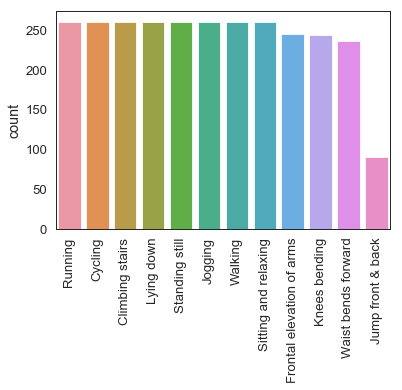

In [22]:
sns.set_context("paper", font_scale=1.5)                                                  
plt.figure()
sns.countplot(record_full.subject)

plt.figure()
sns.countplot(record_full.label.map(label_map),order = record_full.label.value_counts().index.map(lambda x: label_map[x]))
plt.xticks(rotation=90)
plt.xlabel('')

Since the filtering is fair for different subjects and motion types, the overall distribution stays the same.

#### Signal trace examples

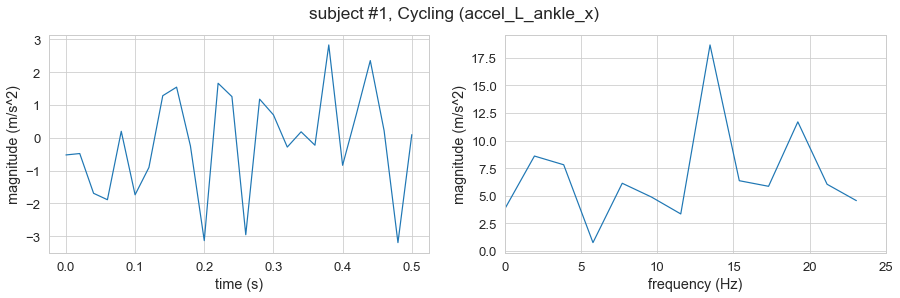

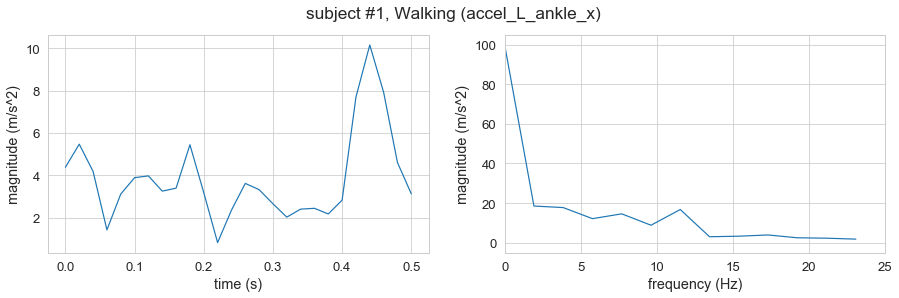

In [23]:
sns.set_style("whitegrid")
label = 9
subject = 1
sensor = 'accel_L_ankle_x'
fig = plt.figure(figsize=(15,4))
fig.suptitle('subject #'+str(subject)+', '+str(label_map[label])+' ('+sensor+')')
plt.subplot(121)
signal_t(record_full,label,subject,sensor)
plt.subplot(122)
signal_f(record_full,label,subject,sensor)

label = 4
subject = 1
sensor = 'accel_L_ankle_x'
fig = plt.figure(figsize=(15,4))
fig.suptitle('subject #'+str(subject)+', '+str(label_map[label])+' ('+sensor+')')
plt.subplot(121)
signal_t(record_full,label,subject,sensor)
plt.subplot(122)
signal_f(record_full,label,subject,sensor)

Now the duration of the signals is short, it is really difficult to see repetitive patterns of any motion. 

Similarly, their 2D structure can be observed by applying t-SNE. The dataset is already small in this case and the entire dataset can be used for calculation.
#### t-SNA

In [24]:
X = record_full.drop(['subject','label'],axis=1) #subject feature cause data leakage
y = record_full[['subject','label']]

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
tsne = TSNE(random_state=100,verbose=1,perplexity=90)
X_scaled_tsne = tsne.fit_transform(X_scaled)

[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 2895 samples in 0.005s...
[t-SNE] Computed neighbors for 2895 samples in 0.562s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2895
[t-SNE] Computed conditional probabilities for sample 2000 / 2895
[t-SNE] Computed conditional probabilities for sample 2895 / 2895
[t-SNE] Mean sigma: 1.354112
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.185715
[t-SNE] KL divergence after 1000 iterations: 0.585769


In [25]:
df_tsna = pd.concat([pd.DataFrame(X_scaled_tsne,columns=['tsna_0','tsna_1']),y.subject.reset_index(drop=True),y.label.map(lambda x: label_map[x]).reset_index(drop=True)],axis=1)

#### t-SNA figure by motion

Text(0.5, 1.0, 't-SNE plot by motion')

<Figure size 432x288 with 0 Axes>

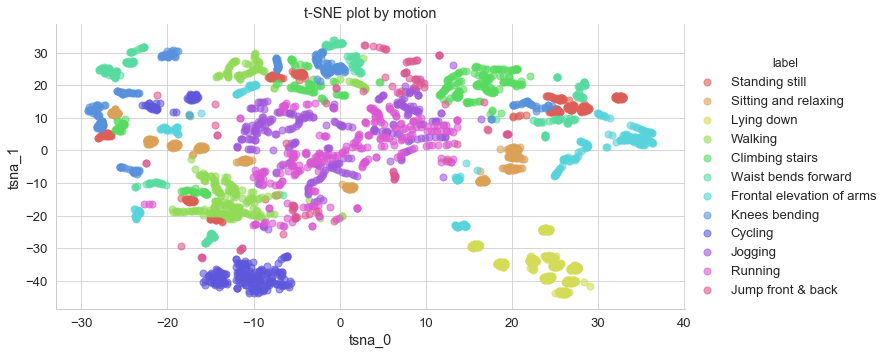

In [26]:
plt.figure()
sns.lmplot('tsna_0','tsna_1',hue='label',fit_reg=False,scatter_kws={'alpha':0.6,"s": 50},
           data=df_tsna,aspect=2,palette=sns.color_palette("hls", 12),hue_order=label_map.values())
plt.title('t-SNE plot by motion')

#### t-SNA figure by motion of specific subject

Text(0.5, 1.0, 't-SNE plot by motion of subject#1')

<Figure size 432x288 with 0 Axes>

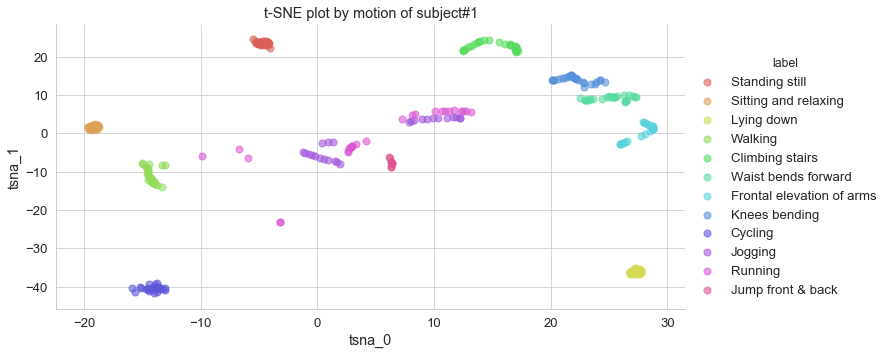

In [27]:
plt.figure()
sns.lmplot('tsna_0','tsna_1',hue='label',fit_reg=False,scatter_kws={'alpha':0.6,"s": 50},
           data=df_tsna[df_tsna['subject']==1],aspect=2,palette=sns.color_palette("hls", 12),hue_order=label_map.values())
plt.title('t-SNE plot by motion of subject#1')

#### t_SNA figure by subject

Text(0.5, 1.0, 't-SNE plot by subject')

<Figure size 432x288 with 0 Axes>

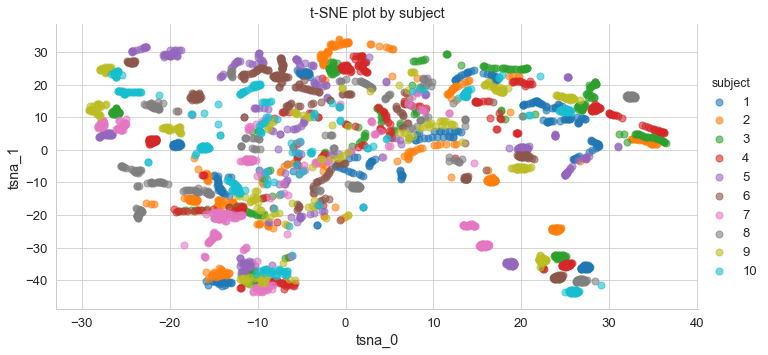

In [28]:
plt.figure()
sns.lmplot('tsna_0','tsna_1',hue='subject',fit_reg=False,scatter_kws={'alpha':0.6,"s": 50},
           data=df_tsna,aspect=2)
plt.title('t-SNE plot by subject')

#### t_SNA figure by subject during specific motion

Text(0.5, 1.0, 't-SNE plot by subject while Climbing stairs')

<Figure size 432x288 with 0 Axes>

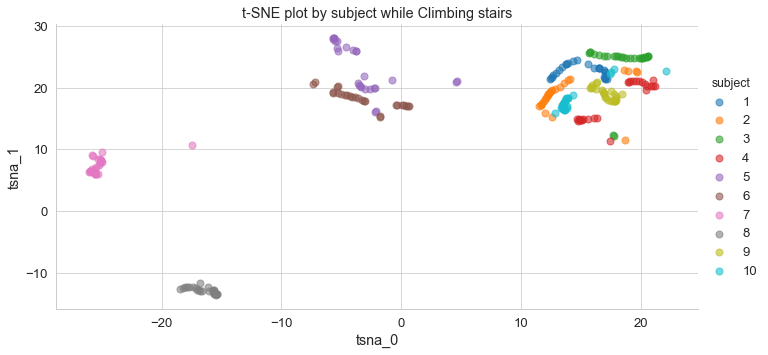

In [29]:
plt.figure()
sns.lmplot('tsna_0','tsna_1',hue='subject',fit_reg=False,scatter_kws={'alpha':0.6,"s": 50},
           data=df_tsna[df_tsna['label']=='Climbing stairs'],aspect=2)
plt.title('t-SNE plot by subject while Climbing stairs')

The clusters are not perfectly separated, but the model is still expected to give high accuracy in prediction. 

This subset of data being used (~ 0.5 sec) is maybe too small for model training. This can be easily checked by drawing its learning curve.

#### Learning curve

In [30]:
from sklearn.model_selection import learning_curve
X = record_full.drop(['subject','label'],axis=1) #subject feature cause data leakage
y = record_full[['subject','label']]
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=100)
y_train_subject = y_train.subject
y_train_label = y_train.label
y_test_subject = y_test.subject
y_test_label = y_test.label
train_sizes, train_scores, valid_scores = learning_curve(XGBClassifier(), X_train, y_train_label, cv=3, train_sizes =np.linspace(0.0001, 1.0, 10))

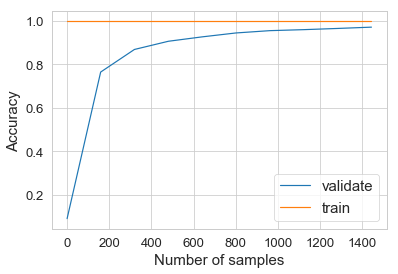

In [31]:
plt.figure()
plt.plot(train_sizes,np.mean((valid_scores),axis=1),label='validate')
plt.plot(train_sizes,np.mean((train_scores),axis=1),label='train')
plt.xlabel('Number of samples',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.legend(fontsize=15)

Based on the learning curve below, it is shown that 0.5-sec-long data is long enough to train the model with decent prediction accuracy. 

The model is now evaluaed on the test set.
#### Model fitting and evaluation on the test set

In [32]:
xgbc_motion = XGBClassifier().fit(X_train,y_train_label)
xgbc_subject = XGBClassifier().fit(X_train,y_train_subject)
print('Accurcay to predict motion: {:.3f}'.format(xgbc_motion.score(X_test,y_test_label)))
print('Accuracy to predict subject: {:.3f}'.format(xgbc_subject.score(X_test,y_test_subject)))

Accurcay to predict motion: 0.968
Accuracy to predict subject: 0.939


#### Feature importance of each model

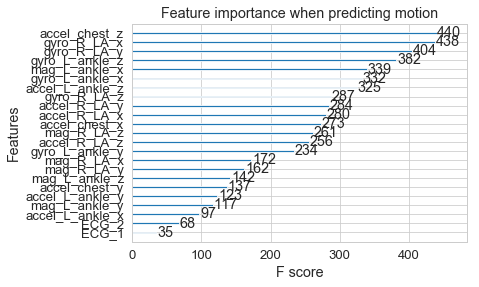

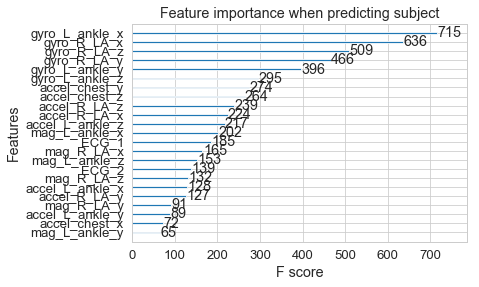

In [33]:
plot_importance(xgbc_motion,title='Feature importance when predicting motion')
plot_importance(xgbc_subject,title='Feature importance when predicting subject')

Suprisingly, the prediction accuracy is shown to be higher with less amount of data. This is possibly because the variation of each motion gets smaller as the motion last longer due to tiredness. Only using the small subset of data in the beginning of each motion, this model can **predict the motion and subject with ~97% and 94% accuracy, respectively**.

#### Model for personal motion prediction 

In [34]:
subject_motion = []
for subject in np.sort(record_full.subject.unique()):
    record_motion = record_full[record_full.subject==subject]
    X = record_motion.drop(['subject','label'],axis=1) #subject feature cause data leakage
    y = record_motion[['subject','label']]

    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=100)
    y_train_label = y_train.label
    y_test_label = y_test.label
    
    xgbc = XGBClassifier().fit(X_train,y_train_label)
    top3 = pd.DataFrame(xgbc.feature_importances_,index=X_train.columns,columns=['F score']).sort_values('F score',ascending=False).index[0:3].tolist()
    
    y_predicted = xgbc.predict(X_test)
    acc_score = accuracy_score(y_test_label,y_predicted)
    subject_motion.append([subject,acc_score.round(3),top3[0],top3[1],top3[2]])
pd.DataFrame(subject_motion,columns=['Subject','Accuracy','Feature1','Feature2','Feature3']).set_index('Subject')

,Accuracy,Feature1,Feature2,Feature3
Subject,,,,
1,0.960,gyro_R_LA_y,gyro_R_LA_x,accel_chest_z
2,1.000,gyro_L_ankle_x,gyro_R_LA_y,gyro_R_LA_x
3,0.960,gyro_L_ankle_x,gyro_L_ankle_z,gyro_R_LA_z
4,0.920,gyro_L_ankle_z,gyro_R_LA_x,gyro_L_ankle_x
5,1.000,gyro_L_ankle_x,gyro_R_LA_z,gyro_R_LA_y
6,0.985,gyro_R_LA_x,ECG_2,gyro_R_LA_z
7,0.959,gyro_R_LA_x,gyro_R_LA_y,gyro_L_ankle_x
8,0.986,gyro_L_ankle_x,gyro_R_LA_z,gyro_R_LA_y
9,0.973,gyro_R_LA_y,gyro_L_ankle_x,accel_chest_z


The accuracy of specific models are still very high. The model sees the first 0.5-second-long data in each of individual's motions and then can **predict the motion of that specific subject with high accuracy**. Depending on the subject, the most important features are slightly different, but usually it is the **gyro** sensor that provides the most information. 

#### Model for identifying subject based on motions  

In [35]:
motion_subject = []
for motion in np.sort(record_full.label.unique()):
    record_motion = record_full[record_full.label==motion]
    X = record_motion.drop(['subject','label'],axis=1) #subject feature cause data leakage
    y = record_motion[['subject','label']]

    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=100)
    y_train_subject = y_train.subject
    y_test_subject = y_test.subject
    
    xgbc = XGBClassifier().fit(X_train,y_train_subject)
    top3 = pd.DataFrame(xgbc.feature_importances_,index=X_train.columns,columns=['F score']).sort_values('F score',ascending=False).index[0:3].tolist()
    
    y_predicted = xgbc.predict(X_test)
    acc_score = accuracy_score(y_test_subject,y_predicted)
    motion_subject.append([label_map[motion],acc_score.round(3),top3[0],top3[1],top3[2]])
pd.DataFrame(motion_subject,columns=['Motion','Accuracy','Feature1','Feature2','Feature3']).set_index('Motion')

,Accuracy,Feature1,Feature2,Feature3
Motion,,,,
Standing still,1.000,gyro_R_LA_x,gyro_L_ankle_x,accel_chest_y
Sitting and relaxing,1.000,accel_L_ankle_x,accel_chest_z,gyro_R_LA_y
Lying down,0.985,gyro_L_ankle_y,gyro_L_ankle_x,accel_L_ankle_x
Walking,0.985,gyro_R_LA_x,gyro_L_ankle_x,accel_R_LA_z
Climbing stairs,0.985,gyro_L_ankle_y,gyro_L_ankle_x,gyro_R_LA_x
Waist bends forward,1.000,gyro_L_ankle_x,gyro_R_LA_z,gyro_R_LA_x
Frontal elevation of arms,0.984,gyro_L_ankle_x,gyro_L_ankle_z,accel_L_ankle_x
Knees bending,1.000,gyro_L_ankle_x,gyro_R_LA_y,gyro_R_LA_x
Cycling,0.938,gyro_R_LA_x,gyro_R_LA_z,mag_L_ankle_x


The result shows that this specific model can accurately identify the subject when the subject is in a specific type of motion that the model is trained for. Even for `climbing stairs` that the model trained with 60-sec-long data shows relatively lower accuracy, this model with smaller amount of data shows almost perfect accuracy.

The last analysis that may be intersting is to test the model performance when the model is trained by the information from specific sensors only. For this purpose, the wrist sensors are chosen to simulate the model training by generic smart watches.
# Model fitting with small subset of data (0.5-second-long) from wrist sensors - XGB Classifier

#### Model fitting and evaluation on the test set

In [36]:
record_full = record_full[['accel_R_LA_x', 'accel_R_LA_y', 'accel_R_LA_z', 'gyro_R_LA_x', 'gyro_R_LA_y', 'gyro_R_LA_z',
                           'mag_R_LA_x', 'mag_R_LA_y', 'mag_R_LA_z', 'label', 'subject']]
X = record_full.drop(['subject','label'],axis=1) #subject feature cause data leakage
y = record_full[['subject','label']]
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=100)
y_train_subject = y_train.subject
y_train_label = y_train.label
y_test_subject = y_test.subject
y_test_label = y_test.label

xgbc_motion = XGBClassifier().fit(X_train,y_train_label)
xgbc_subject = XGBClassifier().fit(X_train,y_train_subject)
print('Accurcay to predict motion: {:.3f}'.format(xgbc_motion.score(X_test,y_test_label)))
print('Accuracy to predict subject: {:.3f}'.format(xgbc_subject.score(X_test,y_test_subject)))

Accurcay to predict motion: 0.959
Accuracy to predict subject: 0.874


The results are suprising. Relying on only sensors on the wrist, the model can predict motion and subject with great accuracy. When more specific models are built, the prediction accuracy is expected to be even higher.

#### Feature importnance of each model

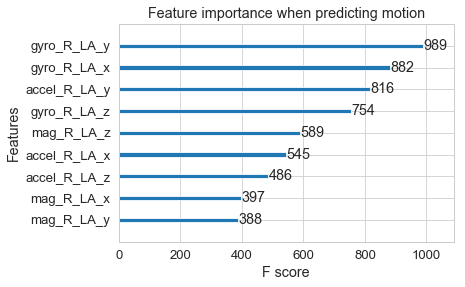

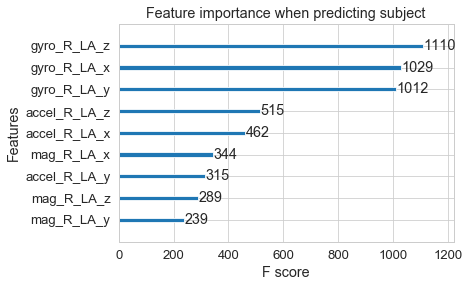

In [37]:
plot_importance(xgbc_motion,title='Feature importance when predicting motion')
plot_importance(xgbc_subject,title='Feature importance when predicting subject')

#### Model for personal motion prediction 

In [38]:
subject_motion = []
for subject in np.sort(record_full.subject.unique()):
    record_motion = record_full[record_full.subject==subject]
    X = record_motion.drop(['subject','label'],axis=1) #subject feature cause data leakage
    y = record_motion[['subject','label']]

    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=100)
    y_train_label = y_train.label
    y_test_label = y_test.label
    
    xgbc = XGBClassifier().fit(X_train,y_train_label)
    top3 = pd.DataFrame(xgbc.feature_importances_,index=X_train.columns,columns=['F score']).sort_values('F score',ascending=False).index[0:3].tolist()
    
    y_predicted = xgbc.predict(X_test)
    acc_score = accuracy_score(y_test_label,y_predicted)
    subject_motion.append([subject,acc_score.round(3),top3[0],top3[1],top3[2]])
pd.DataFrame(subject_motion,columns=['Subject','Accuracy','Feature1','Feature2','Feature3']).set_index('Subject')

,Accuracy,Feature1,Feature2,Feature3
Subject,,,,
1,0.920,gyro_R_LA_y,gyro_R_LA_z,gyro_R_LA_x
2,0.973,gyro_R_LA_y,gyro_R_LA_x,accel_R_LA_z
3,0.973,gyro_R_LA_y,gyro_R_LA_z,gyro_R_LA_x
4,1.000,gyro_R_LA_x,gyro_R_LA_y,gyro_R_LA_z
5,1.000,gyro_R_LA_y,gyro_R_LA_x,gyro_R_LA_z
6,0.985,gyro_R_LA_x,gyro_R_LA_z,accel_R_LA_z
7,0.959,gyro_R_LA_x,gyro_R_LA_y,gyro_R_LA_z
8,0.958,gyro_R_LA_z,gyro_R_LA_y,gyro_R_LA_x
9,0.945,gyro_R_LA_y,gyro_R_LA_z,gyro_R_LA_x


#### Model for identifying subject based on motions  

In [39]:
motion_subject = []
for motion in np.sort(record_full.label.unique()):
    record_motion = record_full[record_full.label==motion]
    X = record_motion.drop(['subject','label'],axis=1) #subject feature cause data leakage
    y = record_motion[['subject','label']]

    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=100)
    y_train_subject = y_train.subject
    y_test_subject = y_test.subject
    
    xgbc = XGBClassifier().fit(X_train,y_train_subject)
    top3 = pd.DataFrame(xgbc.feature_importances_,index=X_train.columns,columns=['F score']).sort_values('F score',ascending=False).index[0:3].tolist()
    
    y_predicted = xgbc.predict(X_test)
    acc_score = accuracy_score(y_test_subject,y_predicted)
    motion_subject.append([label_map[motion],acc_score.round(3),top3[0],top3[1],top3[2]])
pd.DataFrame(motion_subject,columns=['Motion','Accuracy','Feature1','Feature2','Feature3']).set_index('Motion')

,Accuracy,Feature1,Feature2,Feature3
Motion,,,,
Standing still,1.000,gyro_R_LA_x,gyro_R_LA_y,accel_R_LA_z
Sitting and relaxing,1.000,accel_R_LA_x,accel_R_LA_z,accel_R_LA_y
Lying down,1.000,accel_R_LA_x,accel_R_LA_y,gyro_R_LA_z
Walking,0.954,gyro_R_LA_x,gyro_R_LA_z,gyro_R_LA_y
Climbing stairs,0.985,gyro_R_LA_z,gyro_R_LA_x,gyro_R_LA_y
Waist bends forward,0.966,gyro_R_LA_x,gyro_R_LA_z,accel_R_LA_z
Frontal elevation of arms,0.984,accel_R_LA_x,mag_R_LA_z,gyro_R_LA_y
Knees bending,1.000,gyro_R_LA_x,gyro_R_LA_z,gyro_R_LA_y
Cycling,1.000,gyro_R_LA_x,gyro_R_LA_y,gyro_R_LA_z


# Conclusion

Even though the training dataset could be highly biased (coming from only 10 different subjects), this project showed that ***the monitoring devices with minimal amount of sensors and data (~0.5 seconds) can predict different motions and even identify the specific subject with almost perfect accuracy (~ >95%)***. The sensor that contributed most to such high prediction accuracy was the **gyro** sensors that measure the rate of turn in deg/s.

This may suggest that most mobile phones and smart watches can have an easy access to these types of user-specific private information. When used for good purposes, it can be beneficial. However, in the opposite case, it may cause a serious breach in user privacy.